In [1]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
from examples.ista import sol_2_obj_diff
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval, k_steps_train_ista, create_projection_fn, lin_sys_solve, k_steps_train_fista
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.ista_model import ISTAmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.ista import generate_b_mat
from scipy.spatial import distance_matrix
from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


(CVXPY) Apr 25 12:04:07 PM: Encountered unexpected exception importing solver OSQP:
ImportError("dlopen(/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/osqp/_osqp.cpython-39-darwin.so, 0x0002): symbol not found in flat namespace '_csc_matrix'")


In [23]:
# ista setup
N_train = 1000
N_test = 20
N = N_train + N_test
m, n = 50, 50
A = jnp.array(np.random.normal(size=(m, n)))
b_mat = jnp.array(np.random.normal(size=(N, m)))
# b_mat = generate_b_mat(A, N)
k = 100000
z0 = jnp.zeros(n)
lambd = .5
evals, evecs = jnp.linalg.eigh(A.T @ A)
ista_step = 1 / jnp.max(evals)

# setup inputs
b_mat_train = b_mat[:N_train, :]
b_mat_test = b_mat[N_train:, :]
train_inputs = b_mat_train
test_inputs = b_mat_test

In [24]:
 # solve with cvxpy
z_stars, objvals = solve_many_probs_cvxpy(A, b_mat, lambd)
objvals_train = objvals[:N_train]
objvals_test = objvals[N_train:]
z_stars_train = z_stars[:N_train, :]
z_stars_test = z_stars[N_train:, :]

# create relative obj fn
partial_rel = partial(sol_2_obj_diff, A=A, lambd=lambd)
batch_rel = vmap(partial_rel, in_axes=(0, 0, 0), out_axes=(0))
batch_rel_mat = vmap(batch_rel, in_axes=(1, None, None), out_axes=(0))

finished solving cvxpy problems


In [25]:
# create l2ws_model
# nn_cfg = {'lr': 1e-5} 
nn_cfg = {}
# nn_cfg = {'intermediate_layer_sizes': [200]} #, 'lr': 1e-1}
train_unrolls = 50
input_dict = dict(algorithm='ista',
                    supervised=False,
                    train_unrolls=train_unrolls, 
                    jit=True,
                    train_inputs=train_inputs, 
                    test_inputs=test_inputs,
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    lambd=lambd,
                    ista_step=ista_step,
                    A=A,
                    nn_cfg=nn_cfg,
                    z_stars_train=z_stars_train,
                    z_stars_test=z_stars_test,
                    )
l2ws_model = ISTAmodel(input_dict)

In [26]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = l2ws_model.evaluate(k, nearest_neighbors_z, b_mat_test, z_stars=z_stars_test, fixed_ws=True, tag='test')
nn_z_all = nn_eval_out[1][3]
nn_rel_objs = batch_rel_mat(nn_z_all, b_mat_test, objvals_test).mean(axis=1)
nn_losses = nn_eval_out[1][1].mean(axis=0)

# evaluate test before training
init_test_loss, init_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
init_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)
init_z_all = init_eval_out[1][3]
init_rel_objs = batch_rel_mat(init_z_all, b_mat_test, objvals_test).mean(axis=1)

distances [[10.44706993  8.16740506  9.63676669 ...  8.26605966 11.55500589
   9.58393216]
 [ 8.79624549  9.92295562 11.25913029 ... 10.18254671 11.62953571
  10.45453724]
 [11.44821703 11.02642196 12.00307432 ... 10.53890275 11.18178906
  10.65410197]
 ...
 [ 9.62218552 10.14872367 11.30648439 ...  8.96095857 11.1297605
  10.22234831]
 [10.19509656  9.79951474 10.06406474 ...  9.84094658  9.26840378
   9.95062633]
 [10.89461051  9.58672561 11.17971879 ... 10.49214565 10.89114819
   9.84952515]]
indices [802 123 468 458 253 775 892 149 426 714 626 591  73 106 775 198 309 462
 784 149]
best val [7.00366263 7.81817448 8.22768369 8.03152621 7.16002938 7.44900979
 7.30665265 7.41415454 7.39209169 6.86202484 8.055782   7.09206278
 6.59037275 7.20637383 6.65802953 7.28342647 7.05840864 7.412845
 6.5172625  8.01782022]


In [27]:
# call train_batch without jitting
params, state = l2ws_model.params, l2ws_model.state
num_epochs = 100
losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = l2ws_model.train_full_batch(params, state)
    loss, params, state = train_result
    losses = losses.at[i].set(loss)

l2ws_model.params, l2ws_model.state = params, state

In [28]:
# evaluate test after training
final_test_loss, final_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
final_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_z_all = final_eval_out[1][3]
final_rel_objs = batch_rel_mat(final_z_all, b_mat_test, objvals_test).mean(axis=1)

final_test_losses = final_eval_out[1][1].mean(axis=0)

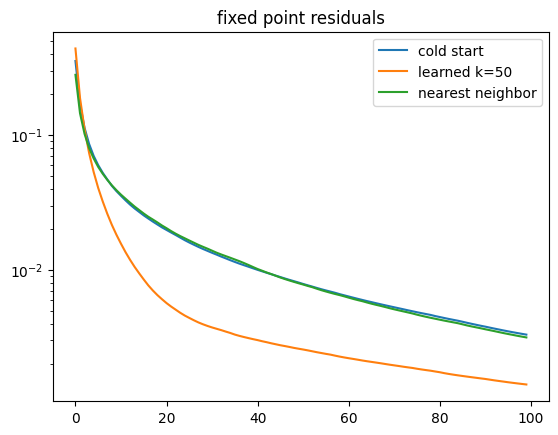

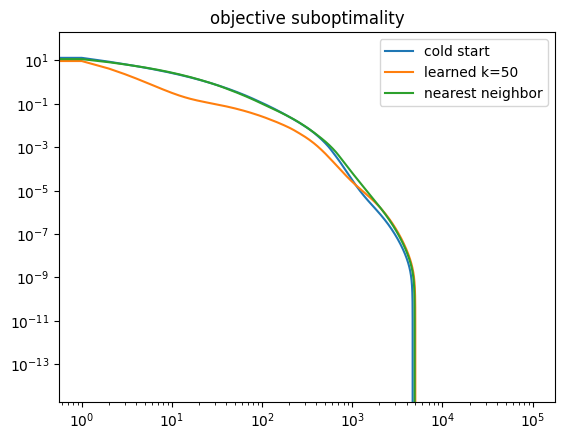

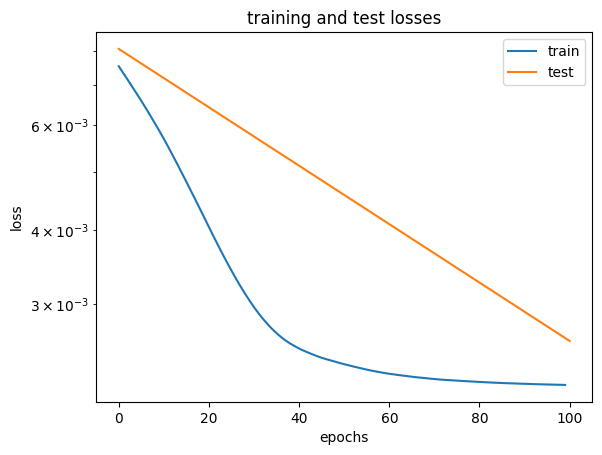

In [32]:
plt.plot(init_test_losses[:100], label='cold start')
plt.plot(final_test_losses[:100], label=f"learned k={train_unrolls}")
plt.plot(nn_losses[:100], label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
# plt.xlim((0,100))

plt.title('fixed point residuals')
plt.legend()
plt.show()

plt.plot(init_rel_objs, label='cold start')
plt.plot(final_rel_objs, label=f"learned k={train_unrolls}")
plt.plot(nn_rel_objs, label='nearest neighbor')
plt.yscale('log')
plt.xscale('log')
plt.title('objective suboptimality')
plt.legend()
plt.show()

plt.plot(losses, label='train')
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training and test losses')
plt.legend()
plt.show()